<img src="images/arm_logo.png" width=500 alt="ARM Logo"></img>

# Bankhead National Forest - CMAC/RadClss Rain Rates Investigation

## Overview

The Corrected Moments to Antenna Coordinates (CMAC) Value-Added Product (VAP) is designed to provide a quality assured dataset which includes pre-processing and corrections for the significant influence of attenuation in rain, specific differential phase measurements to better account for non-uniform beam filling and anticipated beam blockage, and the anticipated need to de-aliasing Doppler velocities in severe convective cloud contexts 

The Extracted Radar Columns and In-Situ Sensors (RadClss) Value-Added Product (VAP) is
a dataset containing in-situ ground observations matched to CSAPR-2 radar columns above ARM Mobile Facility (AMF-3) supplemental sites of interest. 

Together, these products allow for the investigation of radar derived rain rates within BNF. 

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| [GeoPandas](https://geopandas.org/en/stable/docs.html) | Necessary | Familiarity with Geospatial Plotting|
| [Py-ART / Radar Foundations](https://projectpythia.org/radar-cookbook/README.html) | Necessary | Basics of Weather Radar | 

- **Time to learn**: 30 minutes

## Current List of Supported RadCLss Sites
| Site  | Lat   | Lon   |
| ----- | ----- | ----- |
| M1    | 34.34525 | -87.33842 |
| S4    | 34.46451 | -87.23598 |
| S20   | 34.65401 | -87.29264 |
| S30   | 34.38501 | -86.92757 |
| S40   | 34.17932 | -87.45349 |



<img src="images/bnf-cmac-radclss-moasic.20250305.015921.png" width=1500 alt="BNF Mosaic Radar Display"></img>

In [48]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import glob
import os
import datetime
import tempfile
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xarray as xr
import pandas as pd
import dask
import cartopy.crs as ccrs

from math import atan2 as atan2
from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.img_tiles import OSM
from matplotlib.transforms import offset_copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from dask.distributed import Client, LocalCluster
from metpy.plots import USCOUNTIES
from PIL import Image

import act
import pyart

dask.config.set({'logging.distributed': 'error'})

## Define Processing Variables

In [2]:
# Define the desired processing date for the BNF CSAPR-2 in YYYY-MM-DD format.
DATE = "2025-03-05"
# Define the directory where the BNF CSAPR-2 CMAC files are located.
RADAR_DIR = "/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/"
# Define an output directory for downloaded ground instrumentation
INSITU_DIR = "/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/in_situ/"

In [3]:
# Define the RadCLss file
RADCLSS = sorted(glob.glob("data/bnf-csapr2-radclss.c2." + "*" + DATE.replace('-', '') + '*.nc'))

## Define Functions 

In [46]:
def create_gif(file_location, out_dir, date):
    # Define files created and define movie path
    map_images = sorted(glob.glob(file_location + f"/bnf-cmac-radclss-moasic*"))
    gif_title = out_dir + f"bnf-cmac-radclss-moasic-" + date + ".gif"

    # Check to see if the file exists - if it does, delete it
    if os.path.exists(gif_title):
        os.remove(gif_title)

    # Step 2: Open images using Pillow
    frames = [Image.open(f) for f in map_images]

    # Step 3: Save as GIF with 2.5s per frame
    frames[0].save(
        gif_title,
        save_all=True,
        append_images=frames[1:],
        duration=850,  # Duration in ms
        loop=0          # Loop forever
    )

In [4]:
def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
    
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 3.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)

## RadCLss Corrected Reflectivity Display

In [6]:
ds = xr.open_dataset(RADCLSS[0])

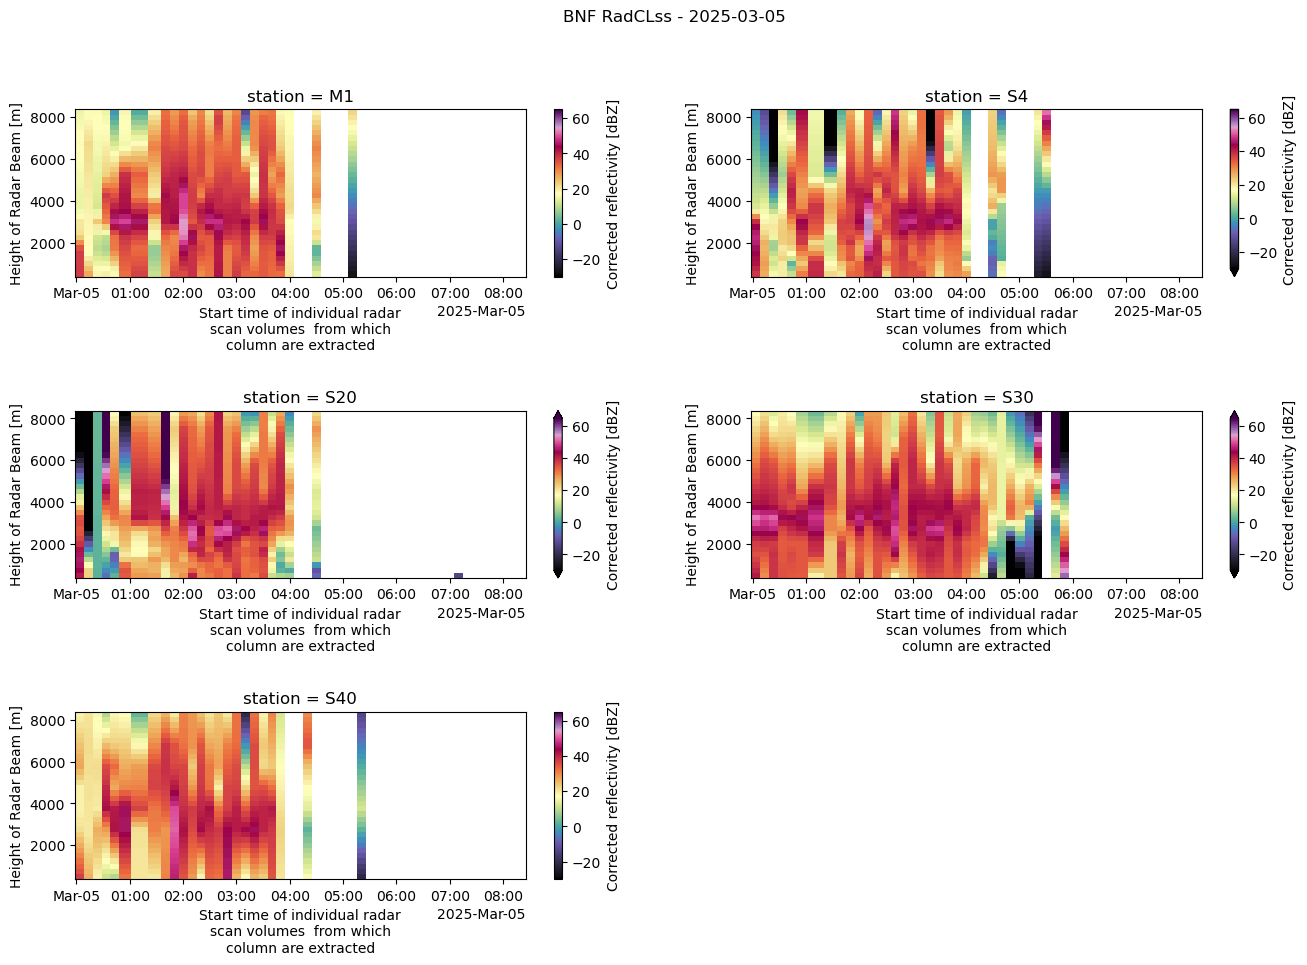

In [7]:
fig, axarr = plt.subplots(3, 2, figsize=[16, 10])
plt.subplots_adjust(hspace=0.8)

fig.suptitle("BNF RadCLss - " + DATE)

ds.sel(station="M1").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T08:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[0, 0], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S4").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T08:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[0, 1], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S20").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T08:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[1, 0], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S30").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T08:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[1, 1], vmin=-30, vmax=65, cmap="ChaseSpectral")
ds.sel(station="S40").sel(time=slice("2025-03-05T00:00:00", "2025-03-05T08:30:00")).corrected_reflectivity.plot(y="height", ax=axarr[2, 0], vmin=-30, vmax=65, cmap="ChaseSpectral")

axarr[2, 1].set_visible(False)

## Mosaic Display - CMAC Parameters with RadCLss Extracted Column

In [44]:
def bnf_mosasic_display(cmac, 
                        radclss, 
                        field="corrected_reflectivity", 
                        vmin=-5, 
                        vmax=65, 
                        dis_site="M1",
                        out_dir="./"):
    """
    Create a display to visualize CMAC Reflectivity across
    the domain, marking locations of the extracted columns,
    and displaying slices over the site of interest. 

    Input
    -----
    cmac : str
        Path to Corrected Moments to Antenna Coordinates (CMAC) file 
    radclss : str
        Path to Extracted Radar Columns and In-Situ Sensors (RadCLss)
    field : str
        Specific radar parameter to display
    vmin : int
        Minimum value to display between all subplots for the specific radar
        parameter
    vmax : int
        Maximum value to display between all subplots for the specific radar
        parameter
    dis_site : str
        Identifer of the supported location for lat/lon slices
    out_dir : str
        Path to location to save figure to

    Returns
    -------
    STATUS : bool
        bool flag to determine if generated plot saved
    """
    #------------------
    # Inputs
    #------------------
    
    # Open the files
    try:
        radar = pyart.io.read(cmac)
        # skip the RHI scans for now
        if radar.scan_type != "sector":
            return
        # check for those weird files
        if radar.elevation['data'].shape[0] < 1:
            return
    except:
        return
    
    ds = xr.open_dataset(radclss)

    # define the sites of interest
    nsite = {"M1" : [34.34525, -87.33842],
             "S4" : [34.46451, -87.23598],
             "S3" : [34.63080, -87.13311],
             "S20" : [34.65401, -87.29264],
             "S30" : [34.38501, -86.92757],
             "S40" : [34.17932, -87.45349]}

    # define the center of the map to be the CSAPR2
    central_lon = -87.13076
    central_lat = 34.63080

    #---------------------------------------------------
    # Define the GridSpec for Detailed Subplot Placement
    #---------------------------------------------------

    fig = plt.figure(figsize=(18, 8))
    tiler = OSM()
    mercator = tiler.crs

    # define the main subplot
    gs0 = gridspec.GridSpec(1, 2, figure=fig)
    gs00 = gs0[1].subgridspec(3, 1, hspace=.32, wspace=0.75)

    # update the extent of the subplot
    #gs0.update(top=.90, bottom=0.1, left=0.1, right=.95)
     # update the extent of the subplot
    #gs0.update(top=.90, bottom=0.1, left=0.1, right=.95)

    #--------------------------------------
    # Main Plot - Display the CMAC Field
    #--------------------------------------
    # Create a subplot and define projection
    ax = fig.add_subplot(gs0[0], projection=ccrs.PlateCarree())

    # Add some various map elements to the plot to make it recognizable.
    ax.add_feature(cfeature.COASTLINE)
    ax.add_image(tiler, 9, zorder=2, alpha=0.35)
    # Set the BNF Domain (adjust later for various groups)
    ax.set_extent([272.0, 274.0, 35.1, 34.1])
    gl = ax.gridlines(draw_labels=True)
    # Hide the right side ticks
    ax.tick_params(labeltop=False, labelright=False)

    # Add the column sites
    markers = ["p", "*", "+", "D", "o", "s"]
    for i, site in enumerate(nsite):
            ax.scatter(nsite[site][1],
                       nsite[site][0],
                       marker=markers[i],
                       color="black",
                       s=75,
                       label=site,
                       zorder=3,
                       transform=ccrs.PlateCarree())
        
            # Use the cartopy interface to create a matplotlib transform object
            # for the Geodetic coordinate system. We will use this along with
            # matplotlib's offset_copy function to define a coordinate system which
            # translates the text by 25 pixels to the left.
            # note - taken from cartopy examples
            geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
            text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

            if site == "S3":
                # Add text 25 pixels to the left of the volcano.
                ax.text(nsite[site][1]+0.07, 
                        nsite[site][0]+0.035, 
                        "CSAPR-2", 
                        verticalalignment='center', 
                        horizontalalignment='right', 
                        transform=text_transform,
                        bbox=dict(facecolor='sandybrown', 
                        alpha=0.5, 
                        boxstyle='round'))
            else:
                # Add text 25 pixels to the left of the volcano.
                ax.text(nsite[site][1]-0.035, 
                        nsite[site][0]+0.04, 
                        site, 
                        verticalalignment='center', 
                        horizontalalignment='right', 
                        transform=text_transform,
                        bbox=dict(facecolor='sandybrown', 
                        alpha=0.5, 
                        boxstyle='round'))

    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map(field,  
                         vmin=vmin, 
                         vmax=vmax,
                         ax=ax,
                         cmap="ChaseSpectral",
                         zorder=1,
                         colorbar_flag=False,
                        )

    ims = display.plots[0]
    cbar = fig.colorbar(ims, ax=ax, location="bottom", shrink=0.6, pad=0.1)
    cbar_label = ("CMAC " +
                  radar.fields["corrected_reflectivity"]["long_name"] +  
                 '\n [' + 
                 radar.fields["corrected_reflectivity"]["units"] + ']'
    )
    cbar.set_label(cbar_label)

    # Add our scale bar
    add_scale_line(35.0, ax, projection=ccrs.PlateCarree(), 
                   color='black', linewidth=3,
                   fontsize=12,
                   fontweight='bold')

    #------------------------------
    # Cumulative Subplot Parameters
    #------------------------------
    # Define the time of the radar file we are plotting against
    radar_time = pyart.util.datetimes_from_radar(radar)[-1]
    final_time = radar_time + timedelta(days=1)

    #-----------------------------------------------
    # Side Plot A - Display the RadClss Radar Field
    #-----------------------------------------------
    # Top right hand subplot - Radar TimeSeries
    ax2 = fig.add_subplot(gs00[0])

    ds[field].sel(station=dis_site).sel(
         time=slice(radar_time.strftime("%Y-%m-%dT00:00:00"), radar_time.strftime("%Y-%m-%dT%H:%M:%S"))
         ).plot(x="time", 
                ax=ax2, 
                cmap="ChaseSpectral",
                vmin=vmin,
                vmax=vmax
    )
    
    ax2.set_title("BNF Site: " + dis_site)
    ax2.set_ylabel("Height [m]")
    ax2.set_xlabel("Time [UTC]")
    ax2.set_xlim([radar_time.strftime("%Y-%m-%dT00:00:00"), final_time.strftime("%Y-%m-%dT00:00:00")])

    #--------------------------------------
    # Side Plot B - Display the Rain Rates
    #--------------------------------------
    # Top right hand subplot - Radar TimeSeries
    ax3 = fig.add_subplot(gs00[1])

    # CMAC derived rain rate
    ds["rain_rate_A"].sel(station=dis_site).sel(height=100, method="nearest").sel(
         time=slice(radar_time.strftime("%Y-%m-%dT00:00:00"), radar_time.strftime("%Y-%m-%dT%H:%M:%S"))
         ).plot(x="time", 
                ax=ax3,
                label="CMAC"
    )

    # Pluvio2 Weighing Bucket Rain Gauge
    if dis_site == "M1":
        ds["intensity_rtnrt"].sel(station=dis_site).sel(
            time=slice(radar_time.strftime("%Y-%m-%dT00:00:00"), radar_time.strftime("%Y-%m-%dT%H:%M:%S"))
            ).plot(x="time",
                   ax=ax3,
                   label="PLUVIO2"
        )

    # LDQUANTS derived rain rate
    if dis_site == "M1" or dis_site == "S30":
        ds["rain_rate"].sel(station=dis_site).sel(
            time=slice(radar_time.strftime("%Y-%m-%dT00:00:00"), radar_time.strftime("%Y-%m-%dT%H:%M:%S"))
            ).plot(x="time",
                   ax=ax3,
                   label="LDQUANTS"
        )
            
    ax3.set_title(" ")
    ax3.set_ylabel("Precipitation Rate [mm/hr]")
    ax3.set_xlabel("Time [UTC]")
    ax3.set_xlim([radar_time.strftime("%Y-%m-%dT00:00:00"), final_time.strftime("%Y-%m-%dT00:00:00")])
    ax3.legend(loc="upper right")
    ax3.grid(True)
    # Add a blank space next to the subplot to shape it as the above plot
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="3%", pad=1.05)
    cax.set_visible(False)

    #------------------------------------------
    # Side Plot C - Precipitation Accumulation
    #------------------------------------------
    ax4 = fig.add_subplot(gs00[2])
   
    # CMAC Accumulated Rain Rates
    radar_accum = act.utils.accumulate_precip(ds.sel(station=dis_site).isel(height=4), 'rain_rate_A').compute()
    # CMAC Accumulated Rain Rates
    radar_accum['rain_rate_A_accumulated'].sel(
         time=slice(radar_time.strftime("%Y-%m-%dT00:00:00"), radar_time.strftime("%Y-%m-%dT%H:%M:%S"))
         ).plot(x="time", 
                ax=ax4,
                label="CMAC"
    )

    # PLUVIO2 Accumulation 
    if dis_site == "M1":
        gauge_precip_accum = act.utils.accumulate_precip(ds.sel(station=dis_site), 'intensity_rtnrt').intensity_rtnrt_accumulated.compute()
        gauge_precip_accum.sel(
            time=slice(radar_time.strftime("%Y-%m-%dT00:00:00"), radar_time.strftime("%Y-%m-%dT%H:%M:%S"))
            ).plot(x="time", 
                   ax=ax4,
                   label="PLUVIO2"
        )

    # LDQUANTS Accumulation
    if dis_site == "M1" or dis_site == "S30":
         ld_precip_accum = act.utils.accumulate_precip(ds.sel(station=dis_site), 'rain_rate').rain_rate_accumulated.compute()
         ld_precip_accum.sel(
            time=slice(radar_time.strftime("%Y-%m-%dT00:00:00"), radar_time.strftime("%Y-%m-%dT%H:%M:%S"))
            ).plot(x="time", 
                   ax=ax4,
                   label="LDQUANTS"
        )  
    
    ax4.set_title(" ")
    ax4.set_ylabel("Accumulated Precipitation [mm]")
    ax4.set_xlabel("Time [UTC]")
    ax4.set_xlim([radar_time.strftime("%Y-%m-%dT00:00:00"), final_time.strftime("%Y-%m-%dT00:00:00")])
    ax4.legend(loc="upper left")
    ax4.grid(True)
    ax4.set_ylim(0, radar_accum["rain_rate_A_accumulated"].max()+0.25)
    # Add a blank space next to the subplot to shape it as the above plot
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes("right", size="3%", pad=1.05)
    cax.set_visible(False)

    # Set the DPI to a higher value (e.g., 300)
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300

    # save the figure
    try:
        fig.savefig(out_dir + 
                    'bnf-cmac-radclss-moasic.' + 
                    radar_time.strftime("%Y%m%d.%H%M%S") +
                    '.png')
        plt.close(fig)
        STATUS = True
    except:
        STATUS = False

    # Clean up this function 
    del fig, ax, ax2, ax3, ax4
    del gauge_precip_accum, ld_precip_accum, radar_accum
    del radar_time, final_time, tiler
    del radar, ds

    return STATUS

## Create a Daily Mosaic Figure to visualize timeseries

In [45]:
templocation = tempfile.mkdtemp() + "/"
for cmac in file_list[2:]:
    print(cmac)
    mosaic = bnf_mosasic_display(cmac, 
                                 RADCLSS[0],
                                 out_dir=templocation)

/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/bnfcsapr2cmacS3.c1.20250305.001255.nc
/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/bnfcsapr2cmacS3.c1.20250305.001313.nc
/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/bnfcsapr2cmacS3.c1.20250305.002258.nc
/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/bnfcsapr2cmacS3.c1.20250305.002316.nc
/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/bnfcsapr2cmacS3.c1.20250305.003301.nc
/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/bnfcsapr2cmacS3.c1.20250305.003319.nc
/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/bnfcsapr2cmacS3.c1.20250305.004303.nc
/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/bnfcsapr2cmacS3.c1.20250305.004321.nc
/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/bnfcsapr2cmacS3.c1.20250305.005306.nc
/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/bnfcsapr2cmacS3.c1.20250305.005324.nc
/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/bnfcsapr2cmacS3.c1.20250305.010308.nc
/nfs/gce/globalscratch/obrienj/bnf-cmac-r4/bnfcsapr2cmacS3.c1.20250305.011001.nc
/nfs/gce/globalscratch/obrie

In [49]:
create_gif(templocation, "./", DATE)

![BNF CMAC RadCLss Mosaic GIF](data/bnf-cmac-radclss-moasic-2025-03-05_before8Z.gif)

## References

### Surface Meteorological Instrumentation (MET)
- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) **(M1)**.
Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, Supplemental facility at
Courtland **(S20)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, Supplemental facility at
Falkville **(S30)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

- Kyrouac, J., Shi, Y., & Tuftedal, M. Surface Meteorological Instrumentation
(MET), 2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term
Mobile Facility (BNF), Bankhead National Forest, AL, Supplemental facility at
Double Springs **(S40)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1786358

### Balloon-Borne Sounding System (SONDEWNPN)
- Keeler, E., Burk, K., & Kyrouac, J. Balloon-Borne Sounding System (SONDEWNPN),
2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term Mobile
Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) **(M1)**. Atmospheric
Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1595321

### Weighing Bucket Preciptiation Gauge (WBPLUVIO2)
- Zhu, Z., Wang, D., Jane, M., Cromwell, E., Sturm, M., Irving, K., & Delamere, J.
Weighing Bucket Precipitation Gauge (WBPLUVIO2), 2025-03-05 to 2025-03-05,
Bankhead National Forest, AL, USA; Long-term Mobile Facility (BNF), Bankhead
National Forest, AL, AMF3 (Main Site) **(M1)**. Atmospheric Radiation Measurement
(ARM) User Facility. https://doi.org/10.5439/1338194

### Laser Disdrometer Quantities (LDQUANTS)
- Hardin, J., Giangrande, S., & Zhou, A. Laser Disdrometer Quantities (LDQUANTS),
2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term Mobile
Facility (BNF), Bankhead National Forest, AL, AMF3 (Main Site) **(M1)**. Atmospheric
Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1432694

- Hardin, J., Giangrande, S., & Zhou, A. Laser Disdrometer Quantities (LDQUANTS),
2025-03-05 to 2025-03-05, Bankhead National Forest, AL, USA; Long-term Mobile
Facility (BNF), Bankhead National Forest, AL, Supplemental facility at Falkville
**(S30)**. Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1432694